First rows of dataset:
   Participant Condition_name  Condition  Trial  Distance       Power  \
0            7             FB          1      2         1  278.387661   
1            7             FB          1      2         2  292.240750   
2            7             FB          1      1         1  284.804095   
3            7             FB          1      2         3  296.814056   
4            7             FB          1      2         4  295.691226   

     Cadence     HR  PPO  Power_relative_to_PPO  Max_HR  HR_percent_max  
0  88.968692  144.0  438                  63.56   199.0       72.361809  
1  90.749159  151.0  438                  66.72   199.0       75.879397  
2  96.757096  160.0  438                  65.02   199.0       80.402010  
3  91.160566  160.0  438                  67.77   199.0       80.402010  
4  90.980611  163.0  438                  67.51   199.0       81.909548  

Column Data Types:
Participant                int64
Condition_name            object
Conditio

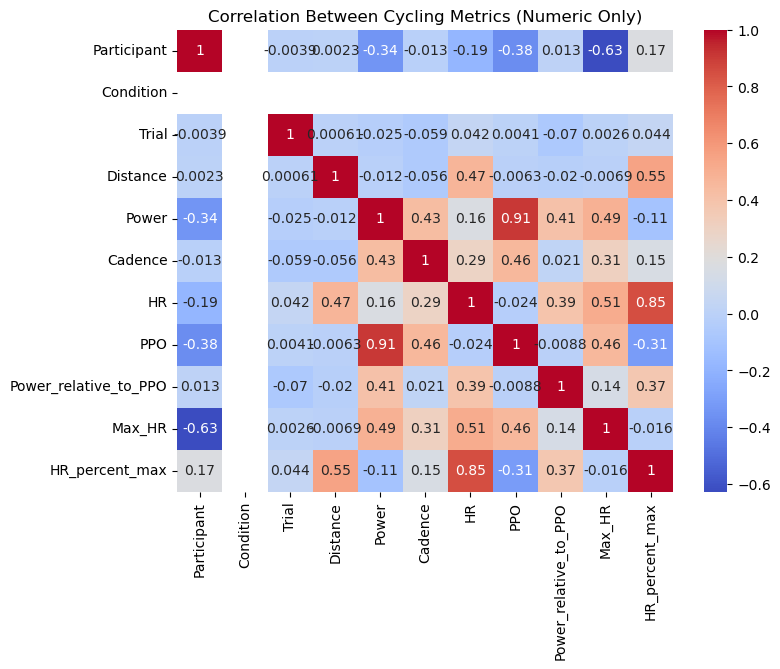

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ------------------ 1. Load Dataset ------------------
df = pd.read_csv("20km_time_trial_cycling.csv")

print("First rows of dataset:")
print(df.head())
print("\nColumn Data Types:")
print(df.dtypes)

# ------------------ 2. Data Cleaning ------------------
# Drop duplicates
df = df.drop_duplicates()

# Handle missing values
df = df.dropna()

# ------------------ 3. Exploratory Data Analysis ------------------
# Only keep numeric columns for correlation
numeric_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Cycling Metrics (Numeric Only)")
plt.show()

# Speed trend over time (if Time column exists)
if "Time" in df.columns and "Speed" in df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(df["Time"], df["Speed"], label="Speed (km/h)")
    plt.xlabel("Time")
    plt.ylabel("Speed")
    plt.title("Cycling Speed Over Time")
    plt.legend()
    plt.show()

# ------------------ 4. Heart Rate Zone Analysis ------------------
if "HeartRate" in df.columns:
    def hr_zone(hr):
        if hr < 100: return "Zone 1"
        elif hr < 120: return "Zone 2"
        elif hr < 140: return "Zone 3"
        elif hr < 160: return "Zone 4"
        else: return "Zone 5"

    df["HR_Zone"] = df["HeartRate"].apply(hr_zone)

    zone_distribution = df["HR_Zone"].value_counts(normalize=True) * 100
    print("\nHeart Rate Zone Distribution (% of ride):")
    print(zone_distribution)

# ------------------ 5. Predictive Model ------------------
# Example: Predict Calories Burned (if Calories column exists)
if "Calories" in df.columns:
    # Pick features that exist in dataset
    candidate_features = ["Speed", "Cadence", "HeartRate", "Distance"]
    features = [col for col in candidate_features if col in df.columns]

    if features:
        X = df[features]
        y = df["Calories"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("\nModel Performance (Calories Prediction):")
        print("Features used:", features)
        print("R2 Score:", r2_score(y_test, y_pred))
        print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
    else:
        print("\nNo suitable numeric features found for predictive modeling.")


Features used: ['Condition_name', 'Distance', 'Cadence', 'HR', 'PPO', 'Power_relative_to_PPO', 'Max_HR', 'HR_percent_max']
Target: Power

Cross-Validation Results:
                    Mean R2    Std R2  Mean RMSE  Std RMSE
Linear Regression  0.991616  0.001219   5.532846  0.354185
Random Forest      0.993256  0.003647   4.812395  1.169489
SVR                0.644907  0.032509  36.198186  3.232894
Gradient Boosting  0.996818  0.000784   3.397834  0.402058


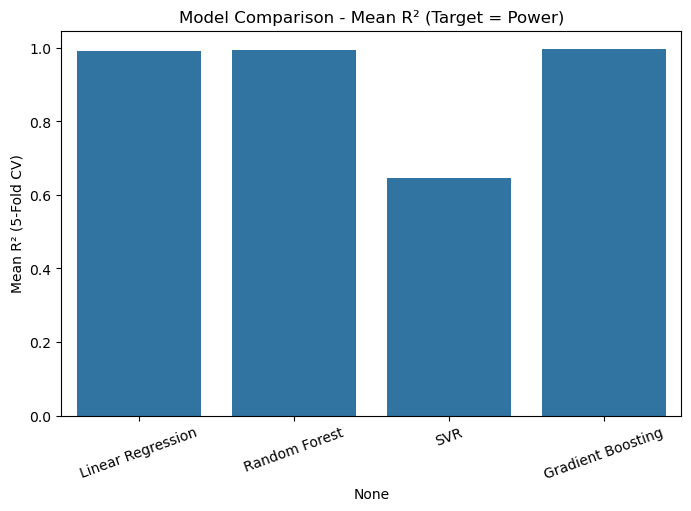

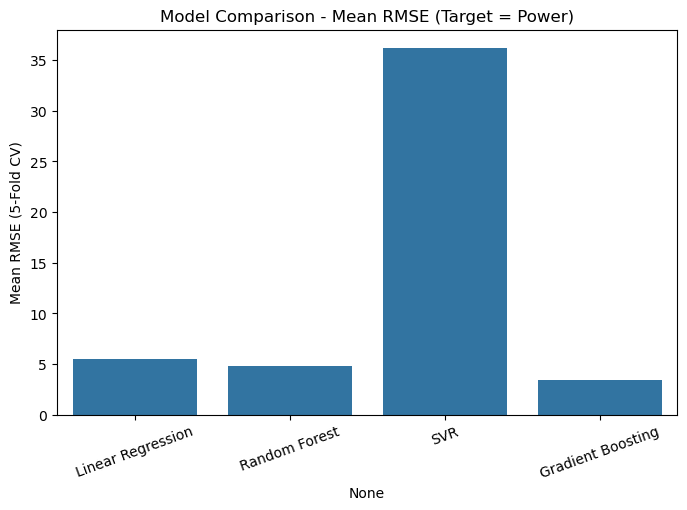

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ------------------ 1. Load & Clean Data ------------------
df = pd.read_csv("20km_time_trial_cycling.csv")
df = df.drop_duplicates().dropna()

# ------------------ 2. Choose Target ------------------
# Example: predict Power from HR, Cadence, etc.
target = "Power"

# Exclude ID-like or categorical columns
exclude_cols = ["Participant", "Condition", "Trial", target]
features = [col for col in df.columns if col not in exclude_cols]

X = df[features].select_dtypes(include=["int64", "float64"])
y = df[target]

print("Features used:", features)
print("Target:", target)

# ------------------ 3. Models ------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": make_pipeline(StandardScaler(), SVR(kernel="rbf")),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# ------------------ 4. Cross Validation ------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
    
    results[name] = {
        "Mean R2": np.mean(scores),
        "Std R2": np.std(scores),
        "Mean RMSE": np.mean(rmse_scores),
        "Std RMSE": np.std(rmse_scores),
    }

# ------------------ 5. Results ------------------
results_df = pd.DataFrame(results).T
print("\nCross-Validation Results:")
print(results_df)

# ------------------ 6. Visualization ------------------
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Mean R2"])
plt.title(f"Model Comparison - Mean R² (Target = {target})")
plt.ylabel("Mean R² (5-Fold CV)")
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Mean RMSE"])
plt.title(f"Model Comparison - Mean RMSE (Target = {target})")
plt.ylabel("Mean RMSE (5-Fold CV)")
plt.xticks(rotation=20)
plt.show()
